In [46]:
#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart

#Boto3 is the AWS SDK
import boto3

#botocore contains core configuration utilities for boto2 and boto3
from botocore.handlers import disable_signing

#Tempory files in Python.. A very useful module
import tempfile

#datetime modules.. very handy!
from datetime import datetime

#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy

#interp
from scipy import interpolate
import numpy as np

%matplotlib inline

In [9]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def find_my_key(radar_name, desired_datetime):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    
    aws_radar = s3.Bucket(bucket)
    
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key, aws_radar

In [10]:
#Lets look at Hurricane Maria
maria_datetime = datetime(2017,9,20,9,0)

#grab the key for Maria
my_key, my_bucket = find_my_key('TJUA', maria_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
my_bucket.download_file(my_key, localfile.name)

#read that file into Py-ART!
radar = pyart.io.read(localfile.name)

2017/09/20/TJUA/TJUA20170920_085854_V06


In [21]:
desired_angle = 20.0
elevations = radar.fixed_angle['data']
val_of_angle = nearest(elevations, desired_angle)
index_of_angle = list(elevations).index(val_of_angle)

In [23]:
qvp_sweep = radar.extract_sweeps([index_of_angle])

In [37]:
zs = qvp_sweep.get_gate_x_y_z(0)[2].mean(axis=0)

In [56]:
desired_variables = ['reflectivity', 'differential_reflectivity']
desired_heights = np.linspace(0.0, 15000.0, 31)
qvp_object = {}
for this_var in desired_variables:
    data_in_radar_gates = qvp_sweep.fields[this_var]['data'].mean(axis=0)
    f = interpolate.interp1d(zs, data_in_radar_gates, 
                             fill_value=pyart.config.get_fillvalue(), bounds_error=False)
    data_interpolated = f(desired_heights)
    qvp_object.update({this_var : np.ma.masked_equal(data_interpolated,pyart.config.get_fillvalue()) })

qvp_object.update({'height' : desired_heights})
    

Text(0,0.5,'Height (m)')

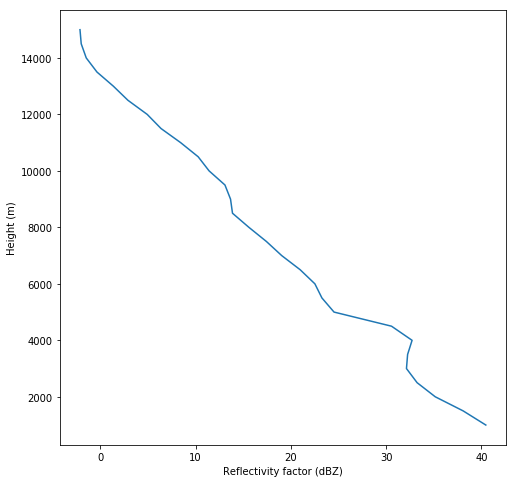

In [60]:
fg = plt.figure(figsize = [8,8])
plt.plot(qvp_object['reflectivity'], qvp_object['height'])
plt.xlabel('Reflectivity factor (dBZ)')
plt.ylabel('Height (m)')

Text(0,0.5,'Height (m)')

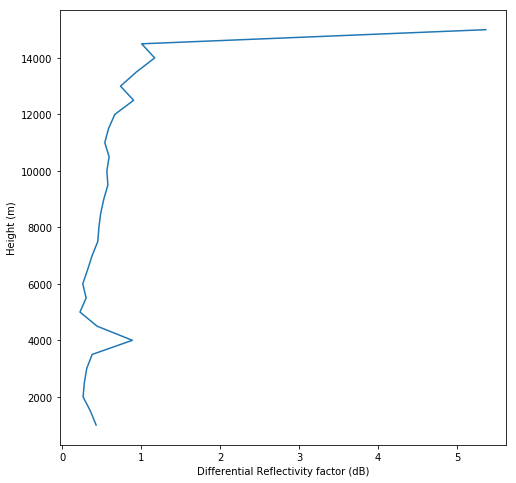

In [61]:
fg = plt.figure(figsize = [8,8])
plt.plot(qvp_object['differential_reflectivity'], qvp_object['height'])
plt.xlabel('Differential Reflectivity factor (dB)')
plt.ylabel('Height (m)')

In [62]:
def QVP(radar_object, desired_angle, vars_to_qvp=('reflectivity'), levels=None):
    """
    Construct a dictionary of QVPs from a given angle. Assumes radar
    is nested PPIs
    
    Parameters
    ----------
    radar_object : pyart.core.Radar object
        Radar object to QVP.
    desired_angle : float
        Angle of elevation to average over.
    
    Other Parameters
    ----------------
    vars_to_qvp : tuple
        variables to QVP over.
    levels : array of floats
        Heights (in m) to interplate to.
        
    Returns
    -------
    qvp : dictionary
        dictionary with keys of vars_to_qvp. Aziumuthal mean at angle closest to desired_angle.
    """
    def _nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))

    if levels is None:
        int_flag = False
    
    elevations = radar_object.fixed_angle['data']
    val_of_angle = _nearest(elevations, desired_angle)
    index_of_angle = list(elevations).index(val_of_angle)
    qvp_sweep = radar_object.extract_sweeps([index_of_angle])
    
    zs = qvp_sweep.get_gate_x_y_z(0)[2].mean(axis=0) #veritical coordinate
    qvp_object = {}
    for this_var in desired_variables:
        data_in_radar_gates = qvp_sweep.fields[this_var]['data'].mean(axis=0)
        if levels is not None:
            f = interpolate.interp1d(zs, data_in_radar_gates, 
                                     fill_value=pyart.config.get_fillvalue(), bounds_error=False)
            data_interpolated = f(levels)
            qvp_object.update({this_var : np.ma.masked_equal(data_interpolated,pyart.config.get_fillvalue()) })
        else:
            qvp_object.update({this_var : data_in_radar_gates})
    
    if levels is None:
        qvp_object.update({'height' : zs})
    else:
        qvp_object.update({'height' : levels})

    return qvp_object
    

In [65]:
my_qvp = QVP(radar, 20.0, levels=np.linspace(0.0, 14000.0, 151))

Text(0,0.5,'Height (m)')

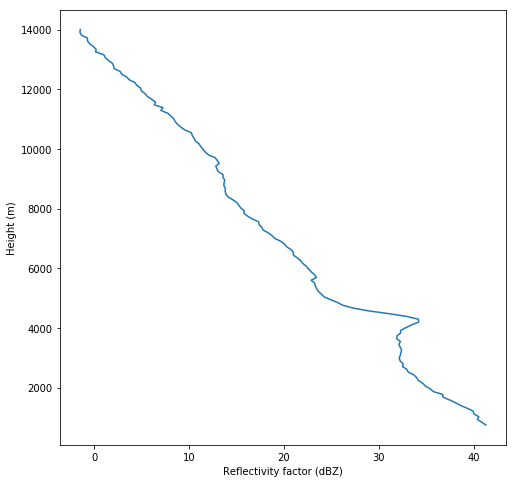

In [66]:
fg = plt.figure(figsize = [8,8])
plt.plot(my_qvp['reflectivity'], my_qvp['height'])
plt.xlabel('Reflectivity factor (dBZ)')
plt.ylabel('Height (m)')

In [67]:
my_qvp_20 = QVP(radar, 20.0, levels=np.linspace(0.0, 14000.0, 151))
my_qvp_15 = QVP(radar, 15.0, levels=np.linspace(0.0, 14000.0, 151))
my_qvp_10 = QVP(radar, 10.0, levels=np.linspace(0.0, 14000.0, 151))


Text(0,0.5,'Height (m)')

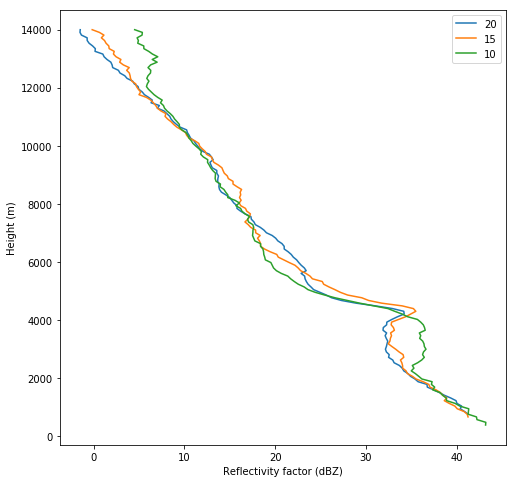

In [69]:
fg = plt.figure(figsize = [8,8])
plt.plot(my_qvp_20['reflectivity'], my_qvp_20['height'], label='20')
plt.plot(my_qvp_15['reflectivity'], my_qvp_15['height'], label='15')
plt.plot(my_qvp_10['reflectivity'], my_qvp_10['height'], label='10')
plt.legend()
plt.xlabel('Reflectivity factor (dBZ)')
plt.ylabel('Height (m)')